 # Train file 
 ---
 For the model we will start by showing that we can purely train on depths 1 and 2 as those are the first instances containing every possible block

In [1]:
### - imports - ###
from PIL import Image
import numpy as np
import glob
import cv2 as cv
import os
import random
import argparse
### - other data augmentation imports - ### (if needed)
### - Imports - ###
import math
import numpy as np
import sklearn as sk #general imports, initial data preprocessing/OS stuff
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os
import torch as T
import torch.nn as nn
import torch.optim as optim #Neural network imports, multiply data etc
from torchvision.transforms import ToTensor
import torchvision.models as models
import torchvision
import torch.nn.functional as F #Neural Network used in Comp4660 at ANU

from torch.autograd import Variable
from torch.optim.lr_scheduler import _LRScheduler

from sklearn.preprocessing import MinMaxScaler #normalize data
from sklearn.metrics import confusion_matrix #analysis
from torchvision import transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset

from torchvision.datasets import ImageFolder
from NetworkMain import D, G
from tqdm import tqdm

Random Seed:  999


C:\Users\campb\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\campb\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
#This code will be added later when the file is converted to a python file
"""parser = argparse.ArgumentParser()
parser.add_argument('--root', type=str, default='./', help='directory contrains the data and outputs')
parser.add_argument('--epochs', type=int, default=40, help='training epoch number')
parser.add_argument('--out_res', type=int, default=128, help='The resolution of final output image')
parser.add_argument('--resume', type=int, default=0, help='continues from epoch number')
parser.add_argument('--cuda', action='store_true', help='Using GPU to train')


opt = parser.parse_args()"""

root = '/Users/campb/Documents/PersonalProjects/AGRNet/'
data_dir = root + 'Dataset/'
check_point_dir = root + 'check_points/'
output_dir = root + 'output/'
weight_dir = root+ 'weight/'
if not os.path.exists(check_point_dir):
	os.makedirs(check_point_dir)
if not os.path.exists(output_dir):
	os.makedirs(output_dir)
if not os.path.exists(weight_dir):
	os.makedirs(weight_dir)

In [3]:
### - Global Variables - ###
DFP = '/Users/campb/Documents/PersonalProjects/AGRNet/Dataset/Sample-'

img_folder = '/Users/campb/Documents/PersonalProjects/AGRNet/Dataset/'

NS = '/Sample-'

image_format = 'RGB'

schedule = [[5, 15, 25 ,35, 40],[16, 16, 16, 8, 4],[5, 5, 5, 1, 1]] #Epochs for each cycle num of epochs

batch_size = schedule[1][0]

growing = schedule[2][0]

epochs = 40

latent_size = 512

out_res = 1024

lr = 1e-4

lambd = 10

In [4]:
device = T.device('cuda:0' if (T.cuda.is_available())  else 'cpu')

transform = transforms.Compose([
            transforms.Resize(out_res),
            transforms.CenterCrop(out_res),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ])
print(device)

cuda:0


In [5]:
#Create networks
Disc = None
Gen = None
Disc = D(latent_size, out_res).to(device)
Gen = G(latent_size, out_res).to(device)

In [6]:
#Noise for discriminator
fixed_noise = T.randn(16, latent_size, 1, 1, device=device)
#initialize optimizers
D_optimizer = optim.Adam(Disc.parameters(), lr=lr, betas=(0, 0.99))
G_optimizer = optim.Adam(Gen.parameters(), lr=lr, betas=(0, 0.99))
#Metric variables
D_running_loss = 0.0
G_running_loss = 0.0
iter_num = 0

D_epoch_losses = []
G_epoch_losses = []

In [7]:
#Load with ImageFolder wrapper
class ImageDataset(Dataset):
    def __init__(self,img_folder,names, transform):
        self.transform = transform
        self.image_names = names #Predetermined dataset
        self.img_folder=img_folder
        
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self,index):
        image=Image.open(self.img_folder+self.image_names[index]).convert("RGB")
        image=self.transform(image)
        return image

assert(os.path.exists(DFP + str(1) + ".jpg"))
rawimgf = sorted(glob.glob(DFP + '*.jpg', recursive = True))
### - image names - ###
imnames = [i.split('/')[-1].split("t")[-1][1:] for i in rawimgf]

### - Global data loader Vars - ###
norms = (0.,0.,0.), (1.0,1.0,1.0)
train_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((out_res, out_res))])
# Parameters
params = {'batch_size': schedule[1][0],
          'shuffle': True,
         'num_workers': 0}

In [8]:
#Control variable
resume = 0
if resume != 0:
    check_point = T.load(check_point_dir+'check_point_epoch_%i.pth' % resume)
    fixed_noise = check_point['fixed_noise']
    G_net.load_state_dict(check_point['G_net'])
    D_net.load_state_dict(check_point['D_net'])
    G_optimizer.load_state_dict(check_point['G_optimizer'])
    D_optimizer.load_state_dict(check_point['D_optimizer'])
    G_epoch_losses = check_point['G_epoch_losses']
    D_epoch_losses = check_point['D_epoch_losses']
    G_net.depth = check_point['depth']
    D_net.depth = check_point['depth']
    G_net.alpha = check_point['alpha']
    D_net.alpha = check_point['alpha']



c = next(x[0] for x in enumerate(schedule[0]) if x[1]>resume)-1
batch_size = schedule[1][c]
growing = schedule[2][c]
dataset = ImageDataset(img_folder, imnames, train_transform)
# dataset = datasets.CelebA(data_dir, split='all', transform=transform)
data_loader = DataLoader(dataset, **params)

tot_iter_num = (len(dataset)/batch_size)
Gen.fade_iters = (1-Gen.alpha)/(schedule[0][c+1]-resume)/(2*tot_iter_num)
Disc.fade_iters = (1-Disc.alpha)/(schedule[0][c+1]-resume)/(2*tot_iter_num)

"""
except:
    print('Fully Grown\n')
    c = -1
    batch_size = schedule[1][c]
    growing = schedule[2][c]

    dataset = ImageDataset(img_folder,imnames, train_transform)
    data_loader = DataLoader(dataset, **params)

    tot_iter_num = (len(dataset)/batch_size)
    print(schedule[0][c], resume)

    if Gen.alpha < 1:
        Gen.fade_iters = (1-Gen.alpha)/(opt.epochs-opt.resume)/(2*tot_iter_num)
        Ddisc.fade_iters = (1-Disc.alpha)/(opt.epochs-opt.resume)/(2*tot_iter_num)"""


"\nexcept:\n    print('Fully Grown\n')\n    c = -1\n    batch_size = schedule[1][c]\n    growing = schedule[2][c]\n\n    dataset = ImageDataset(img_folder,imnames, train_transform)\n    data_loader = DataLoader(dataset, **params)\n\n    tot_iter_num = (len(dataset)/batch_size)\n    print(schedule[0][c], resume)\n\n    if Gen.alpha < 1:\n        Gen.fade_iters = (1-Gen.alpha)/(opt.epochs-opt.resume)/(2*tot_iter_num)\n        Ddisc.fade_iters = (1-Disc.alpha)/(opt.epochs-opt.resume)/(2*tot_iter_num)"

Output Resolution: 4 x 4
epoch: 1/40


  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])


D_loss: 2.443   G_loss: 0.003:   9%|████▋                                               | 1/11 [00:01<00:13,  1.36s/it]

torch.Size([16, 8192])
iteration : 0, gp: 2.70


D_loss: 2.443   G_loss: 0.003:  18%|█████████▍                                          | 2/11 [00:01<00:07,  1.15it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])


D_loss: 2.443   G_loss: 0.003:  27%|██████████████▏                                     | 3/11 [00:02<00:05,  1.53it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])


D_loss: 2.443   G_loss: 0.003:  36%|██████████████████▉                                 | 4/11 [00:02<00:03,  1.81it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])


D_loss: 2.443   G_loss: 0.003:  45%|███████████████████████▋                            | 5/11 [00:03<00:02,  2.00it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])


D_loss: 2.443   G_loss: 0.003:  55%|████████████████████████████▎                       | 6/11 [00:03<00:02,  2.12it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])


D_loss: 2.443   G_loss: 0.003:  64%|█████████████████████████████████                   | 7/11 [00:03<00:01,  2.12it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])


D_loss: 2.443   G_loss: 0.003:  73%|█████████████████████████████████████▊              | 8/11 [00:04<00:01,  2.17it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])


D_loss: 2.443   G_loss: 0.003:  82%|██████████████████████████████████████████▌         | 9/11 [00:04<00:00,  2.21it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])


D_loss: 2.443   G_loss: 0.003: 100%|███████████████████████████████████████████████████| 11/11 [00:05<00:00,  2.06it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([1, 8192])
torch.Size([1, 8192])
torch.Size([1, 3, 4, 4])
torch.Size([1, 8192])
torch.Size([1, 8192])


epoch: 2/40


D_loss: nan   G_loss: nan:   9%|█████                                                   | 1/11 [00:00<00:04,  2.34it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])
iteration : 0, gp: nan


D_loss: nan   G_loss: nan:  18%|██████████▏                                             | 2/11 [00:00<00:03,  2.44it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])


D_loss: nan   G_loss: nan:  27%|███████████████▎                                        | 3/11 [00:01<00:03,  2.39it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])


D_loss: nan   G_loss: nan:  36%|████████████████████▎                                   | 4/11 [00:01<00:02,  2.41it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])


D_loss: nan   G_loss: nan:  45%|█████████████████████████▍                              | 5/11 [00:02<00:02,  2.44it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])


D_loss: nan   G_loss: nan:  55%|██████████████████████████████▌                         | 6/11 [00:02<00:02,  2.43it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])


D_loss: nan   G_loss: nan:  64%|███████████████████████████████████▋                    | 7/11 [00:02<00:01,  2.40it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])


D_loss: nan   G_loss: nan:  73%|████████████████████████████████████████▋               | 8/11 [00:03<00:01,  2.41it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])


D_loss: nan   G_loss: nan:  82%|█████████████████████████████████████████████▊          | 9/11 [00:03<00:00,  2.37it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])


D_loss: nan   G_loss: nan: 100%|███████████████████████████████████████████████████████| 11/11 [00:04<00:00,  2.55it/s]

torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([16, 3, 4, 4])
torch.Size([16, 8192])
torch.Size([16, 8192])
torch.Size([1, 8192])
torch.Size([1, 8192])
torch.Size([1, 3, 4, 4])
torch.Size([1, 8192])
torch.Size([1, 8192])


RuntimeError: [enforce fail at ..\caffe2\serialize\inline_container.cc:300] . unexpected pos 245196288 vs 245196176

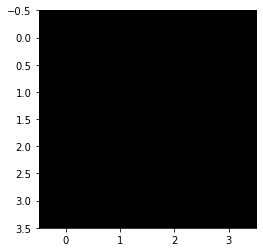

In [9]:
### - Train Loop - ###
size = 2**(Gen.depth+1)
print("Output Resolution: %d x %d" % (size, size))
for epoch in range(1+resume, epochs+1):
    Gen.train()
    D_epoch_loss = 0.0
    G_epoch_loss = 0.0
    if epoch-1 in schedule[0]:

        if (2 **(Gen.depth +1) < out_res):
            c = schedule[0].index(epoch-1)
            batch_size = schedule[1][c]
            growing = schedule[2][0]
            data_loader = DataLoader(dataset, **params)
            tot_iter_num = tot_iter_num = (len(dataset)/batch_size)
            Gen.growing_net(growing*tot_iter_num)
            Disc.growing_net(growing*tot_iter_num)
            size = 2**(Gen.depth+1)
            print("Output Resolution: %d x %d" % (size, size))

	
    print("epoch: %i/%i" % (int(epoch), int(epochs)))
    databar = tqdm(data_loader)
    for i, samples in enumerate(databar):
        ##  update D
        if size != out_res: #Basically need to, A Reshape, B prepare the data for the networks
            samples = F.interpolate(samples, size=(size,size)).to(device)
        else:
            samples = samples.to(device)
        Disc.zero_grad()
        noise = T.randn(samples.size(0), latent_size, 1, 1, device=device)
        fake = Gen(noise)
        out_grid = make_grid(fake, normalize=True, nrow=4, scale_each=True, padding=int(0.5*(2**Gen.depth))).permute(1,2,0)
        plt.imshow(out_grid.cpu())
        fake_out = Disc(fake.detach())
        real_out = Disc(samples)
        ## Gradient Penalty
        
        eps = T.rand(samples.size(0), 1, 1, 1, device=device)
        eps = eps.expand_as(Gen(noise))
        x_hat = eps * samples + (1 - eps) * fake.detach()
        x_hat.requires_grad = True
        print(x_hat.shape)
        px_hat = Disc(x_hat)
        grad = T.autograd.grad(
                                    outputs = px_hat.sum(),
                                    inputs = x_hat, 
                                    create_graph=True
                                    )[0]
        grad_norm = grad.view(samples.size(0), -1).norm(2, dim=1)
        gradient_penalty = lambd * ((grad_norm  - 1)**2).mean()

        ###########

        D_loss = fake_out.mean() - real_out.mean() + gradient_penalty

        D_loss.backward()
        D_optimizer.step()

        ##	update G

        Gen.zero_grad()
        fake_out = Disc(fake)

        G_loss = - fake_out.mean()

        G_loss.backward()
        G_optimizer.step()

        ##############

        D_running_loss += D_loss.item()
        G_running_loss += G_loss.item()

        iter_num += 1


        if i % 500== 0:
            D_running_loss /= iter_num
            G_running_loss /= iter_num
            print('iteration : %d, gp: %.2f' % (i, gradient_penalty))
            databar.set_description('D_loss: %.3f   G_loss: %.3f' % (D_running_loss ,G_running_loss))
            iter_num = 0
            D_running_loss = 0.0
            G_running_loss = 0.0


    D_epoch_losses.append(D_epoch_loss/tot_iter_num)
    G_epoch_losses.append(G_epoch_loss/tot_iter_num)


    check_point = {'G_net' : Gen.state_dict(), 
                   'G_optimizer' : G_optimizer.state_dict(),
                   'D_net' : Disc.state_dict(),
                   'D_optimizer' : D_optimizer.state_dict(),
                   'D_epoch_losses' : D_epoch_losses,
                   'G_epoch_losses' : G_epoch_losses,
                   'fixed_noise': fixed_noise,
                   'depth': Gen.depth,
                   'alpha':Gen.alpha
                   }
    with T.no_grad():
        Gen.eval()
        T.save(check_point, check_point_dir + 'check_point_epoch_%d.pth' % (epoch))
        T.save(Gen.state_dict(), weight_dir + 'G_weight_epoch_%d.pth' %(epoch))
        out_imgs = Gen(fixed_noise)
        out_grid = make_grid(out_imgs, normalize=True, nrow=4, scale_each=True, padding=int(0.5*(2**Gen.depth))).permute(1,2,0)
        plt.imshow(out_grid.cpu())
        plt.savefig(output_dir + 'size_%i_epoch_%d' %(size ,epoch))